In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import scipy.io as io
from pyDOE import lhs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from complexPyTorch.complexLayers import ComplexLinear

import cplxmodule
from cplxmodule import cplx
from cplxmodule.nn import RealToCplx, CplxToReal, CplxSequential, CplxToCplx
from cplxmodule.nn import CplxLinear, CplxModReLU, CplxAdaptiveModReLU, CplxModulus, CplxAngle

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
from lightning_utils import *
from utils import *
from models import (TorchComplexMLP, ImaginaryDimensionAdder, cplx2tensor, 
                    ComplexTorchMLP, ComplexSymPyModule, complex_mse)
from pytorch_robust_pca import *
from preprocess import *

# Model selection
# from sparsereg.model import STRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from RegscorePy.bic import bic

from madgrad import MADGRAD

Running Python 3.7.10
You can use npar for np.array


In [2]:
# torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You're running on", device)

# Adding noise
noise_intensity = 0.01/np.sqrt(2)
noisy_xt = True

# Doman bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])

DATA_PATH = '../experimental_data/NLS.mat'
data = io.loadmat(DATA_PATH)

t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = to_column_vector(Exact_u.T)
v_star = to_column_vector(Exact_v.T)

N = 500
idx = np.random.choice(X_star.shape[0], N, replace=False)
# idx = np.arange(N) # Just have an easy dataset for experimenting

lb = to_tensor(lb, False).to(device)
ub = to_tensor(ub, False).to(device)

# if noisy_xt:
#     print("Noisy (x, t)")
#     X_star = perturb(X_star, intensity=noise_intensity, noise_type="normal")
# else: print("Clean (x, t)")

# X_train = to_tensor(X_star[idx, :], True).to(device)
# u_train = to_tensor(u_star[idx, :], False).to(device)
# v_train = to_tensor(v_star[idx, :], False).to(device)

feature_names = ['hf', '|hf|', 'h_xx']

### Loading (clean) data code here ###
print("Loading pre-calculated (clean) data for reproducibility")
X_train = np.load("./tmp_files/X_train_500+500samples.npy")

if noisy_xt:
    print("Noisy (x, t)")
    X_train = perturb(X_train, intensity=noise_intensity, noise_type="normal")
else: print("Clean (x, t)")

rpca_option = 3
print("Running Robust PCA...")
rpca = R_pca_numpy(X_train)
X_train_L, X_train_S = rpca.fit(tol=1e-20, max_iter=30000, iter_print=1000)
print('Robust PCA Loss:', mean_squared_error(X_train, X_train_L+X_train_S))

X_train = to_tensor(X_train, True)[:N, :]
X_train_L = to_tensor(X_train_L, True)[:N, :]
X_train_S = to_tensor(X_train_S, True)[:N, :]
uv_train = np.load("./tmp_files/uv_train_500samples.npy")
u_train = uv_train[:, 0:1]; v_train = uv_train[:, 1:2]
if noise_intensity > 0.0:
    u_train = perturb(u_train, intensity=noise_intensity, noise_type="normal")
    v_train = perturb(v_train, intensity=noise_intensity, noise_type="normal")
    print("Perturbed u_train and v_train with intensity =", float(noise_intensity))
u_train, v_train = to_tensor(u_train, False), to_tensor(v_train, False)
u_train = u_train[:N, :]; v_train = v_train[:N, :]
h_train = torch.complex(u_train, v_train)

del X_train
### ----- ###

You're running on cpu
Loading pre-calculated (clean) data for reproducibility
Noisy (x, t)
Running Robust PCA...
iteration: 1, error: 5.214361366905212
iteration: 1000, error: 9.776343901985502e-05
iteration: 2000, error: 1.4370710661712087e-11
iteration: 3000, error: 2.262270387157573e-15
iteration: 4000, error: 2.262270387157573e-15
iteration: 5000, error: 2.262270387157573e-15
iteration: 6000, error: 2.262270387157573e-15
iteration: 7000, error: 2.262270387157573e-15
iteration: 8000, error: 2.262270387157573e-15
iteration: 9000, error: 2.262270387157573e-15
iteration: 10000, error: 2.262270387157573e-15
iteration: 11000, error: 2.262270387157573e-15
iteration: 12000, error: 2.262270387157573e-15
iteration: 13000, error: 2.262270387157573e-15
iteration: 14000, error: 2.262270387157573e-15
iteration: 15000, error: 2.262270387157573e-15
iteration: 16000, error: 2.262270387157573e-15
iteration: 17000, error: 2.262270387157573e-15
iteration: 18000, error: 2.262270387157573e-15
iteration:

,sumsquare_error,aic,bic,kl_div
norm,0.892037,535.331981,-7008.187711,inf
uniform,1.433631,463.124087,-6533.729353,inf


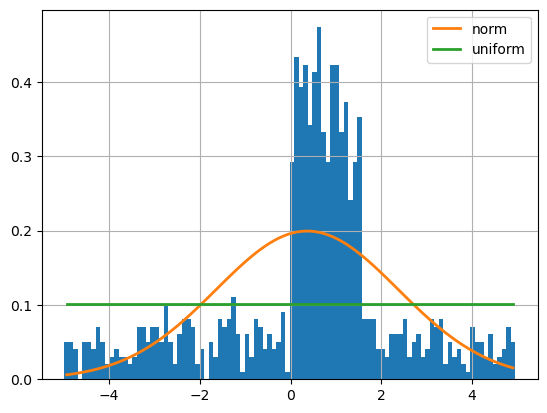

In [3]:
from fitter import Fitter
data = to_numpy(X_train_S).flatten()
d_finder = Fitter(data, distributions=["norm", "uniform"]); d_finder.fit()
d_finder.summary()

In [4]:
cn1 = 0.002494+1.002397*1j
cn2 = 0.003655+0.500415*1j
cns = [cn1, cn2]

In [5]:
# Type the equation got from the symbolic regression step
# No need to save the eq save a pickle file before
program1 = "X0*X1"
pde_expr1, variables1,  = build_exp(program1); print(pde_expr1, variables1)

program2 = "X2"
pde_expr2, variables2,  = build_exp(program2); print(pde_expr2, variables2)

mod = ComplexSymPyModule(expressions=[pde_expr1, pde_expr2], complex_coeffs=cns); mod.train()

X0*X1 {X0, X1}
X2 {X2}


ComplexSymPyModule(
  (sympymodule): SymPyModule(expressions=(X0*X1, X2))
)

In [6]:
class ComplexPINN(nn.Module):
    def __init__(self, model, loss_fn, index2features, scale=False, lb=None, ub=None, beta=False):
        super(ComplexPINN, self).__init__()
        self.model = model
        
        # Beta-Robust PCA
        self.beta = None
        if beta: 
            self.beta = nn.Parameter(data=torch.FloatTensor([0.0]), requires_grad=True)
            self.mean = nn.Parameter(data=torch.zeros((500, 1)), requires_grad=True)
            self.std = nn.Parameter(data=torch.ones((500, 1)), requires_grad=True)

        self.callable_loss_fn = loss_fn
        self.index2features = index2features; self.feature2index = {}
        for idx, fn in enumerate(self.index2features): self.feature2index[fn] = str(idx)
        self.scale = scale; self.lb, self.ub = lb, ub
        if self.scale and (self.lb is None or self.ub is None):
            print("Please provide thw lower and upper bounds of your PDE.")
            print("Otherwise, there will be error(s)")
        self.diff_flag = diff_flag(self.index2features)
        
    def forward(self, H):
        if self.scale: H = self.neural_net_scale(H)
        return self.model(H)
    
    def loss(self, HL, HS, y_input, update_network_params=True, update_pde_params=True):
        total_loss = []
#         H = HL + HS - self.beta*(torch.randn_like(self.std).mul(self.std).add_(self.mean))
        H = HL + HS - self.beta*(torch.normal(self.mean, torch.clamp(self.std, min=0.0)))
        
        grads_dict, u_t = self.grads_dict(H[:, 0:1], H[:, 1:2])
        # MSE Loss
        if update_network_params:
            mse_loss = complex_mse(grads_dict['X'+self.feature2index['hf']], y_input)
            total_loss.append(mse_loss)
        # PDE Loss
        if update_pde_params:
            l_eq = complex_mse(self.callable_loss_fn(grads_dict), u_t)
            total_loss.append(l_eq)
            
        return total_loss
    
    def grads_dict(self, x, t):
        uf = self.forward(cat(x, t))
        u_t = complex_diff(uf, t)
        
        ### PDE Loss calculation ###
        # Without calling grad
        derivatives = {}
        for t in self.diff_flag[0]:
            if t=='hf': 
                derivatives['X'+self.feature2index[t]] = cplx2tensor(uf)
                derivatives['X1'] = (uf.real**2+uf.imag**2)+0.0j
            elif t=='x': derivatives['X'+self.feature2index[t]] = x
        # With calling grad
        for t in self.diff_flag[1]:
            out = uf
            for c in t:
                if c=='x': out = complex_diff(out, x)
                elif c=='t': out = complex_diff(out, t)
            derivatives['X'+self.feature2index['h_'+t[::-1]]] = out
        
        return derivatives, u_t
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))
    
    # Must ensure that the implementation of neural_net_scale is consistent
    # and hopefully correct
    # also, you might not need this function in some datasets
    def neural_net_scale(self, inp): 
        return 2*(inp-self.lb)/(self.ub-self.lb)-1

In [7]:
inp_dimension = 2
act = CplxToCplx[torch.tanh]
complex_model = CplxSequential(
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 1, bias=True),
                            )
complex_model = torch.nn.Sequential(
                                    torch.nn.Linear(inp_dimension, 200),
                                    RealToCplx(),
                                    complex_model
                                    )

/Users/pongpisit/anaconda3/envs/py3.7/lib/python3.7/site-packages/torch/nn/modules/container.py:587: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


In [8]:
# Pretrained model
semisup_model_state_dict = cpu_load("./saved_path_inverse_nls/NLS_complex_model_500labeledsamples_jointtrainwith500unlabeledsamples.pth")
parameters = OrderedDict()

# Filter only the parts that I care about renaming (to be similar to what defined in TorchMLP).
inner_part = "network.model."
for p in semisup_model_state_dict:
    if inner_part in p:
        parameters[p.replace(inner_part, "")] = semisup_model_state_dict[p]
complex_model.load_state_dict(parameters)

pinn = ComplexPINN(model=complex_model, loss_fn=mod, index2features=feature_names, scale=False, lb=lb, ub=ub, beta=True)

In [9]:
def closure():
    global X_train, h_train
    if torch.is_grad_enabled():
        optimizer2.zero_grad(set_to_none=True)
    losses = pinn.loss(X_train_L, X_train_S, h_train, update_network_params=True, update_pde_params=True)
    l = sum(losses)
    if l.requires_grad:
        l.backward(retain_graph=True)
    return l

def mtl_closure():
    global X_train, h_train
    n_obj = 2 # There are two tasks
    losses = pinn.loss(X_train_L, X_train_S, h_train, update_network_params=True, update_pde_params=True)
    updated_grads = []
    
    for i in range(n_obj):
        optimizer1.zero_grad(set_to_none=True)
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in pinn.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(pinn.parameters()): 
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    return sum(losses)

In [10]:
epochs1, epochs2 = 300, 30
# TODO: Save best state dict and training for more epochs.
optimizer1 = MADGRAD(pinn.parameters(), lr=1e-7, momentum=0.9)
pinn.train(); best_train_loss = 1e6

print('1st Phase optimization using Adam with PCGrad gradient modification')
for i in range(epochs1):
    optimizer1.step(mtl_closure)
    if (i % 10) == 0 or i == epochs1-1:
        l = mtl_closure()
        print("Epoch {}: ".format(i), l.item())

1st Phase optimization using Adam with PCGrad gradient modification
Epoch 0:  0.013192374259233475
Epoch 10:  0.009974602609872818
Epoch 20:  0.008491888642311096
Epoch 30:  0.007762376684695482
Epoch 40:  0.007710049394518137
Epoch 50:  0.008349229581654072
Epoch 60:  0.0070140426978468895
Epoch 70:  0.006757463328540325
Epoch 80:  0.006492312066257
Epoch 90:  0.006286589428782463
Epoch 100:  0.0062048062682151794
Epoch 110:  0.006059261970221996
Epoch 120:  0.00590141024440527
Epoch 130:  0.019837988540530205
Epoch 140:  0.0072663817554712296
Epoch 150:  0.008053798228502274
Epoch 160:  0.007072280626744032
Epoch 170:  0.006345926318317652
Epoch 180:  0.006083035841584206
Epoch 190:  0.0059686265885829926
Epoch 200:  0.005840723402798176
Epoch 210:  0.005745231173932552
Epoch 220:  0.005649639293551445
Epoch 230:  0.005566319450736046
Epoch 240:  0.0054940576665103436
Epoch 250:  0.0054267393425107
Epoch 260:  0.005375410430133343
Epoch 270:  0.005325807258486748
Epoch 280:  0.005277

In [11]:
optimizer2 = torch.optim.LBFGS(pinn.parameters(), lr=1e-1, max_iter=500, max_eval=int(500*1.25), history_size=150, line_search_fn='strong_wolfe')
print('2nd Phase optimization using LBFGS')
for i in range(epochs2):
    optimizer2.step(closure)
    if (i % 5) == 0 or i == epochs2-1:
        l = closure()
        print("Epoch {}: ".format(i), l.item())

2nd Phase optimization using LBFGS
Epoch 0:  0.005190030671656132
Epoch 5:  0.005198806989938021
Epoch 10:  0.0051930490881204605
Epoch 15:  0.005182681139558554
Epoch 20:  0.005170617252588272
Epoch 25:  0.005182419903576374
Epoch 29:  0.005178993567824364


In [12]:
# loading weights for testing
# pinn = load_weights(pinn, "./saved_path_inverse_nls/final_finetuned_uncert_cpinn.pth")

In [13]:
est_coeffs = pinn.callable_loss_fn.complex_coeffs().detach().numpy().ravel()
est_coeffs

array([0.00080113+1.0039288j , 0.00082442+0.49846026j], dtype=complex64)

In [14]:
est_coeffs = pinn.callable_loss_fn.complex_coeffs().detach().numpy().ravel()
grounds = np.array([1j, 0+0.5j])

errs = []
for i in range(len(grounds)):
    err = est_coeffs[i]-grounds[i]
    errs.append(100*abs(err.imag)/abs(grounds[i].imag))
errs = np.array(errs)
errs.mean(), errs.std()

(0.3504127264022827, 0.04246532917022705)

In [15]:
# the coeff should be 1.0 (ทำการทดลองไปแล้ว)
pinn.beta.item()

-0.00010761896555777639

In [16]:
# save(pinn, "./saved_path_inverse_nls/noisy2_final_finetuned_betarpca2_cpinn.pth")

#### Results

In [17]:
# Noisy Exact & Clean (x, t)
# (0.05885958671569824, 0.021964311599731445)
# array([-0.00046226+0.99919176j, -0.00056662+0.49981552j], dtype=complex64)
# Noisy Exact & Noisy (x, t)
# (0.6996273994445801, 0.01595020294189453)
# array([0.00149273+0.9928442j, 0.00079829+0.5034184j], dtype=complex64)

# Noisy Exact & Clean (x, t) & X_star = X_star-X_star_S
# (0.7112264633178711, 0.00553131103515625)
# array([ 3.449592e-03+1.007057j , -7.125967e-05+0.5035838j], dtype=complex64)
# Noisy Exact & Noisy (x, t) & X_star = X_star-X_star_S
# (0.7093071937561035, 0.0036716461181640625)
# array([ 3.4442921e-03+1.0070564j, -5.4004795e-05+0.5035649j], dtype=complex64)

# Noisy Exact & Clean (x, t) & X_star = X_star_L+1*X_star_S
# (0.1215517520904541, 0.08192658424377441)
# array([-8.2360100e-05+0.99960375j, -6.1671366e-05+0.5010174j], dtype=complex64)
# Noisy Exact & Noisy (x, t) & X_star = X_star_L+1*X_star_S
# (0.511014461517334, 0.25589466094970703)
# array([-0.01472272+1.0076691j, -0.02164156+0.5012756j], dtype=complex64)

# Noisy Exact & Noisy (x, t) & X_train = X_train_L+1*1*X_train_S+beta*NN(X_train_S)
# (0.5050361156463623, 0.1848280429840088)
# array([ 0.00107117+1.0032021j, -0.01103256+0.5034493j], dtype=complex64)
# beta = 0.005178438033908606
# 
# betarpca2
# reparameterization
# (0.27244389057159424, 0.20924508571624756)
# array([-0.00100172+1.0048169j, -0.00026962+0.499684j ], dtype=complex64)
# beta = -0.0003170908021274954
# torch.normal
# (0.3504127264022827, 0.04246532917022705)
# array([0.00080113+1.0039288j , 0.00082442+0.49846026j], dtype=complex64)
# beta = -0.00010761896555777639

# Notes
# X_star = X_star-X_star_S -> Seems robust but not stable
# X_star = X_star_L+X_star_S -> The best?